In [ ]:
import sys
from pathlib import Path

# allow src folder to be imported from this notebook
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
import json
from pathlib import Path
import seaborn as sns; sns.set_theme()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.blocks import BlockAnalyzer
from src import Block
from src import PositionalString
from tqdm import tqdm; tqdm.pandas()

In [6]:
# INPUTS
path_max_blocks_stats=Path("out/smk_max_blocks.tsv")
dir_max_blocks=Path("out/blocks/")

# load data
df = pd.read_csv(path_max_blocks_stats,sep="\t", index_col=False, header=0)#, nrows=10)


In [7]:

def path_block_from_msa(path_msa):
    name_msa = Path(path_msa).stem
    return dir_max_blocks.joinpath(f"{name_msa}.json")

def gene_or_intergenic(path_msa):
    if Path(path_msa).stem.startswith("GC"):
        return "genic"
    else:
        return "intergenic"


### Load log data from blocks

- `n_seqs`: number of sequences in the MSA
- `n_unique_seqs`: number of unique sequences in the MSA
- `n_cols`: number of columns in the MSA
- `n_max_blocks`: number of maximal blocks in that MSA
- `n_max_blocks_`: binned `n_max_blocks`
- `t`: time spent computing maximal blocks (in seconds)
- `t [min]`: same `t` in minutes
- `t_[min]`: binned `t [min]`
- `max_blocks/size_msa`: proportion [%] of maximal blocks w.r.t the size of the MSA (`n_cols x n_unique_seqs`)

In [8]:

# time in minutes
df["t [min]"] = df["t"]/60

# binned time in minutes
vec_bins=[0,1,10,15,30,45,60,120,180,300,720,1440,10_000] # bins in minutes
t_label_bins = [f"<{bin}" for bin in vec_bins[1:]]
df["t_[min]"]=pd.cut(df["t [min]"], bins=vec_bins, labels=t_label_bins)

# region
df["region"] = df["path_msa"].apply(gene_or_intergenic)    # genic or intergenic region

# max blocks binned
vec_bins=[0,3,5,10,15,50,100,150,200,300,500,1000,1500] # bins blocks
max_blocks_label_bins = [f"<{bin}" for bin in vec_bins[1:]]
df["n_max_blocks_"]=pd.cut(df["n_max_blocks"], bins=vec_bins, labels=max_blocks_label_bins)

In [9]:
# size_msa = n_rows x n_cols, n_rows: n_unique_seqs in the table
df["size_msa"] = df.apply(lambda row: row["n_unique_seqs"]*row["n_cols"], axis=1)

# proportion of maximal blocks w.r.t the size of the msa 
df["max_blocks/size_msa"] = df.apply(lambda row: round(100*row["n_max_blocks"]/row["size_msa"],2),axis=1)

In [10]:
df.head()

,timestamp,path_msa,n_seqs,n_unique_seqs,n_cols,n_max_blocks,t,t [min],t_[min],region,n_max_blocks_,size_msa,max_blocks/size_msa
0,Sat Oct 29 15:55:34 2022,/data/msas/msas/Cluster_13942.fa,19,2,38,2,0.367273,0.006121,<1,intergenic,<3,76,2.63
1,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_12332.fa,19,2,57,2,0.793138,0.013219,<1,intergenic,<3,114,1.75
2,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_11869.fa,4,2,66,4,1.171890,0.019531,<1,intergenic,<5,132,3.03
3,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_10907.fa,11,2,78,2,1.594922,0.026582,<1,intergenic,<3,156,1.28
4,Sat Oct 29 15:55:37 2022,/data/msas/msas/Cluster_10644.fa,155,3,82,5,3.114183,0.051903,<1,intergenic,<5,246,2.03


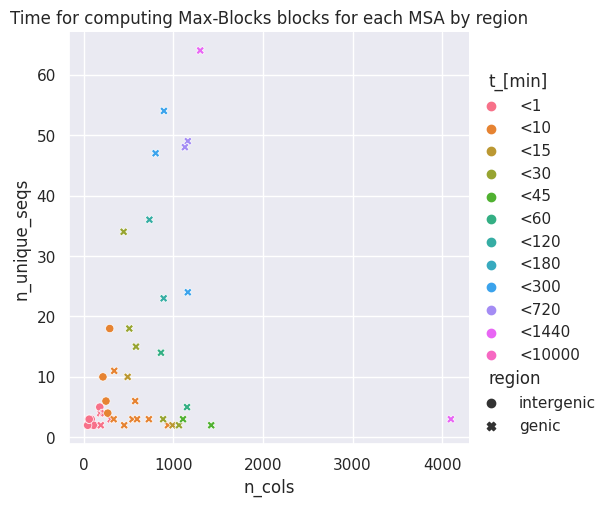

In [11]:
time_plot = sns.relplot(df,
    x="n_cols",
    y="n_unique_seqs",
    hue="t_[min]",
    style="region"
)
time_plot.set(title="Time for computing Max-Blocks blocks for each MSA by region")

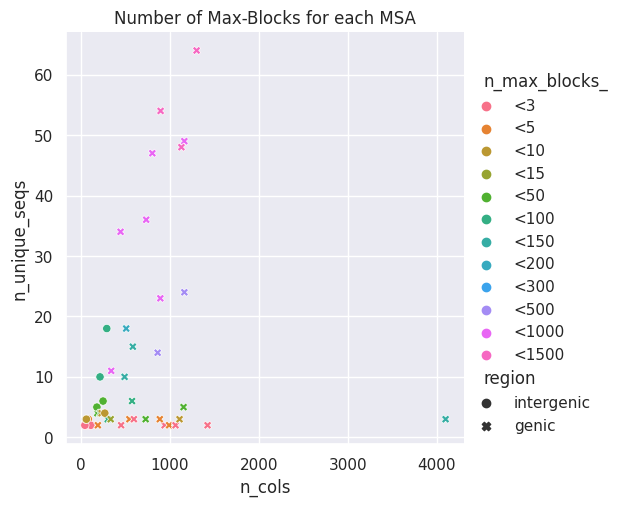

In [12]:
max_block_plot=sns.relplot(df,
    x="n_cols",
    y="n_unique_seqs",
    hue="n_max_blocks_",
    style="region"
)
max_block_plot.set(title="Number of Max-Blocks for each MSA")

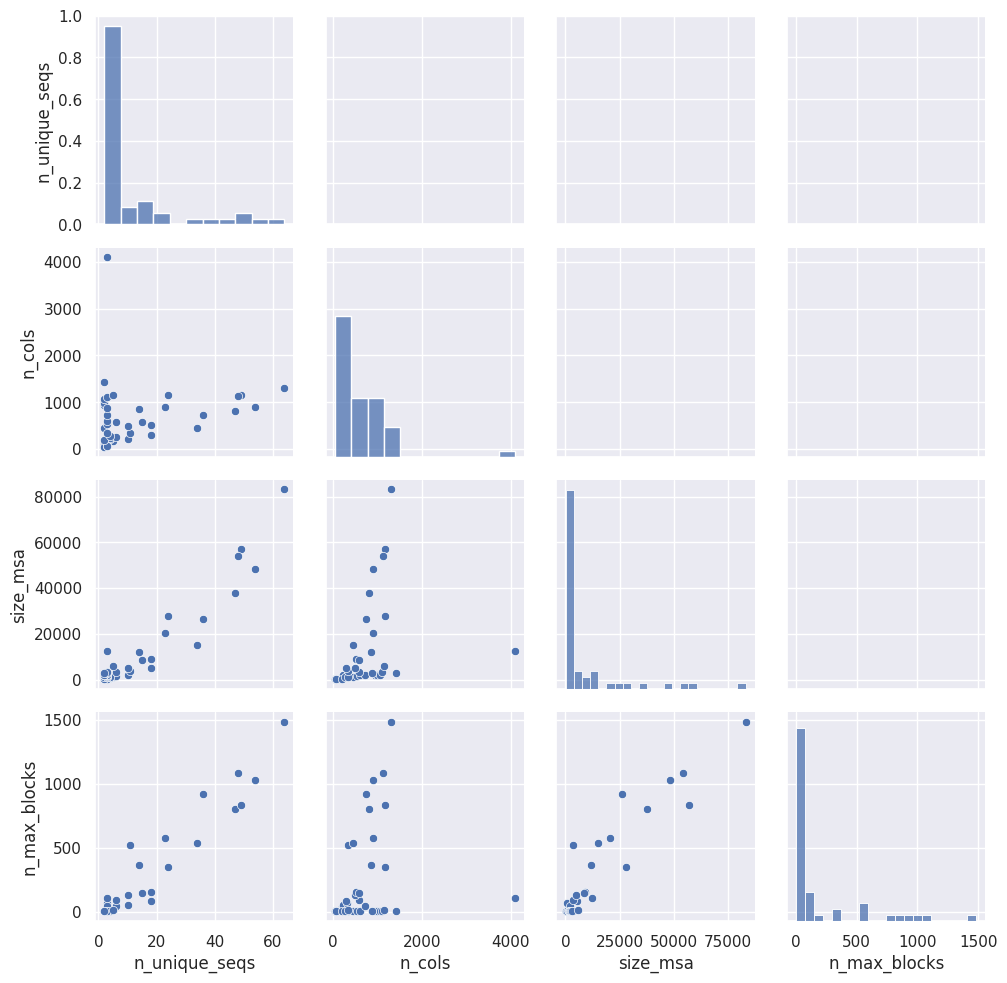

In [13]:
# g = sns.pairplot(data=df[["n_unique_seqs","n_cols","size_msa","t [min]","region"]], hue="region")
g = sns.PairGrid(data=df[["n_unique_seqs","n_cols","size_msa","n_max_blocks","region"]])#, hue="region")
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

# Stats for blocks
- `region`: either Genic or Intergenic
- `number_of_blocks`: number of blocks in the file, in this case is equal to `n_max_blocks`
- `blocks_with_overlap`: number of blocks that overlap at least once with another block
- `inter_between_blocks`: number of intersections between pairs of blocks

In [14]:
# statistics for each block 
block_stats=BlockAnalyzer()

df_stats=df.progress_apply(
    lambda row: block_stats(path_blocks=path_block_from_msa(row["path_msa"])),
    axis=1 ) # output is a dictionary
df = pd.concat([df, pd.DataFrame(list(df_stats))], axis=1) # add stats 
df.to_csv("out/stats_blocks.tsv",sep="\t")
df.head()

100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


,timestamp,path_msa,n_seqs,n_unique_seqs,n_cols,n_max_blocks,t,t [min],t_[min],region,n_max_blocks_,size_msa,max_blocks/size_msa,number_of_blocks,blocks_with_overlap,inter_between_blocks
0,Sat Oct 29 15:55:34 2022,/data/msas/msas/Cluster_13942.fa,19,2,38,2,0.367273,0.006121,<1,intergenic,<3,76,2.63,2,0,0
1,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_12332.fa,19,2,57,2,0.793138,0.013219,<1,intergenic,<3,114,1.75,2,0,0
2,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_11869.fa,4,2,66,4,1.171890,0.019531,<1,intergenic,<5,132,3.03,4,0,0
3,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_10907.fa,11,2,78,2,1.594922,0.026582,<1,intergenic,<3,156,1.28,2,0,0
4,Sat Oct 29 15:55:37 2022,/data/msas/msas/Cluster_10644.fa,155,3,82,5,3.114183,0.051903,<1,intergenic,<5,246,2.03,5,2,5


In [27]:
df["n_max_blocks"].describe()

count      50.000000
mean      192.540000
std       350.623655
min         2.000000
25%         4.000000
50%        15.000000
75%       144.250000
max      1484.000000
Name: n_max_blocks, dtype: float64

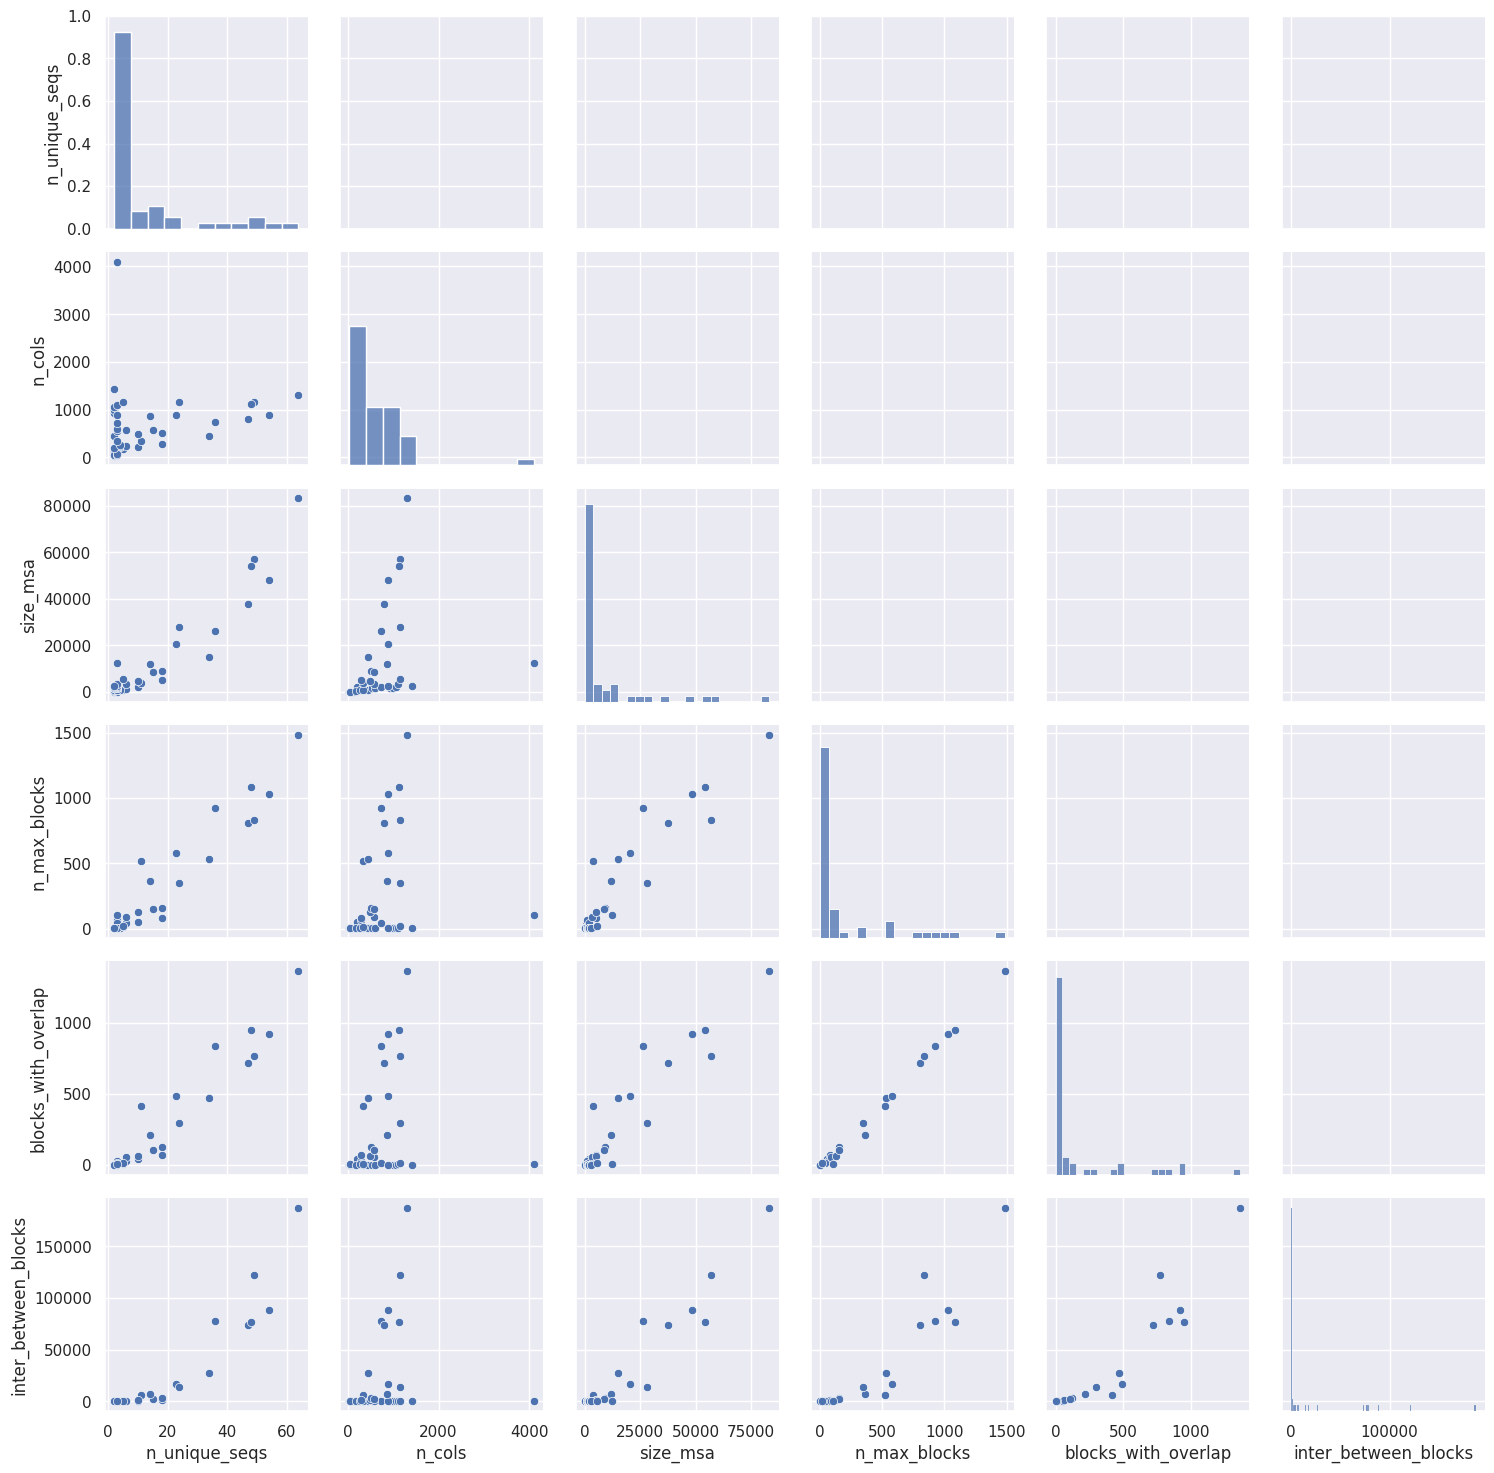

In [16]:
g = sns.PairGrid(data=df[["n_unique_seqs","n_cols","size_msa","n_max_blocks","blocks_with_overlap","inter_between_blocks","region"]])#, hue="region")
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

### mean and max of some features by genic/intergenic region


In [17]:
features0=["n_unique_seqs","n_cols"]
features1=["n_max_blocks","t [min]"]
features2=["blocks_with_overlap", "inter_between_blocks"]
features3=["size_msa","max_blocks/size_msa"]

In [18]:
df.groupby("region")[features0].describe()

n_unique_seqs                                                    \
                   count       mean        std  min  25%  50%    75%   max   
region                                                                       
genic               36.0  14.333333  17.965045  2.0  3.0  4.0  19.25  64.0   
intergenic          14.0   4.571429   4.467219  2.0  2.0  3.0   4.75  18.0   

           n_cols                                                         \
            count        mean         std    min     25%    50%      75%   
region                                                                     
genic        36.0  777.083333  675.429953  177.0  337.50  660.0  1008.00   
intergenic   14.0  127.285714   91.302901   38.0   57.75   80.0   204.25   

                    
               max  
region              
genic       4098.0  
intergenic   289.0

In [19]:
df.groupby("region")[features1].describe()

n_max_blocks                                                  \
                  count        mean         std  min   25%   50%    75%   
region                                                                    
genic              36.0  260.666667  393.483708  2.0  4.75  35.5  404.0   
intergenic         14.0   17.357143   25.037225  2.0  2.25   5.5   18.5   

                   t [min]                                              \
               max   count        mean         std       min       25%   
region                                                                   
genic       1484.0    36.0  105.038068  212.480913  0.185219  1.600133   
intergenic    84.0    14.0    0.656113    1.354664  0.006121  0.018736   

                                              
                  50%        75%         max  
region                                        
genic       14.346342  63.253836  845.469212  
intergenic   0.038589   0.891968    5.061746

In [20]:
df.groupby("region")[features2].describe()

blocks_with_overlap                                           \
                         count        mean         std  min   25%   50%   
region                                                                    
genic                     36.0  219.416667  358.733038  0.0  1.75  10.5   
intergenic                14.0   11.571429   20.545313  0.0  0.00   2.5   

                           inter_between_blocks                              \
               75%     max                count          mean           std   
region                                                                        
genic       326.75  1367.0                 36.0  19615.583333  42316.437439   
intergenic   10.25    69.0                 14.0    190.000000    443.940571   

                                               
            min  25%   50%      75%       max  
region                                         
genic       0.0  4.0  62.0  8668.75  187329.0  
intergenic  0.0  0.0   6.0    82.00    1566.0

In [21]:
df.groupby("region")[features3].describe()

size_msa                                                     \
              count          mean           std    min     25%     50%   
region                                                                   
genic          36.0  12729.250000  19789.686864  372.0  996.75  3082.5   
intergenic     14.0    867.428571   1398.575853   76.0  138.00   200.0   

                             max_blocks/size_msa                            \
                75%      max               count      mean       std   min   
region                                                                       
genic       12994.5  83136.0                36.0  1.945833  2.540672  0.09   
intergenic   1023.5   5202.0                14.0  2.344286  1.042598  0.75   

                                       
              25%   50%    75%    max  
region                                 
genic       0.300  1.52  2.260  13.97  
intergenic  1.645  2.40  2.735   4.94

___
## Draft [do not consider]

In [13]:
import pandas as pd
import seaborn as sns

In [15]:
max_blocks = pd.read_csv("out/smk_max_blocks.tsv",sep="\t", index_col=False)
sub_max_blocks = pd.read_csv("out-sub/smk_max_blocks.tsv",sep="\t", index_col=False)
len(set(max_blocks["path_msa"]).intersection(sub_max_blocks["path_msa"]))

94

<AxesSubplot: xlabel='diff-max-sub', ylabel='Count'>

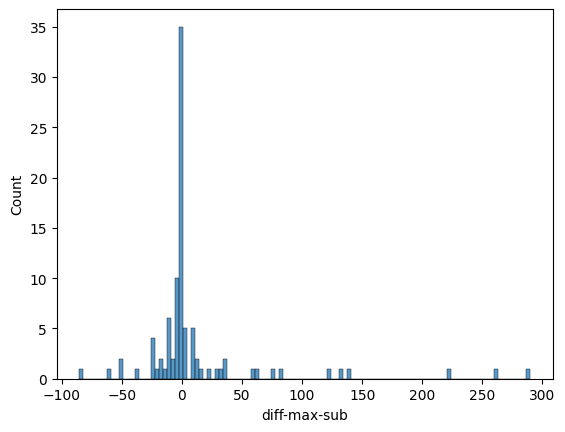

In [21]:
data_times = max_blocks.merge(sub_max_blocks,how="inner", on="path_msa")
data_times["diff-max-sub"] = data_times.apply(lambda row: row["t_y"]- row["t_x"], axis=1)
sns.histplot(data=data_times, x="diff-max-sub")

In [25]:
data_times[data_times["diff-max-sub"]>0].describe()

,n_seqs_x,n_unique_seqs_x,n_cols_x,n_max_blocks_x,t_x,blocks_with_overlap_x,inter_between_blocks_x,n_seqs_y,n_unique_seqs_y,n_cols_y,n_max_blocks_y,t_y,diff-max-sub
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,71.928571,5.952381,123.571429,29.833333,19.581657,21.690476,614.071429,71.928571,5.952381,123.571429,107.428571,60.148190,40.566533
std,78.539222,5.468100,59.630628,42.655693,27.471252,37.808560,1566.947839,78.539222,5.468100,59.630628,238.790769,95.874472,71.630935
min,2.000000,2.000000,37.000000,2.000000,0.367671,0.000000,0.000000,2.000000,2.000000,37.000000,2.000000,0.383132,0.015461
25%,9.250000,2.000000,55.500000,5.000000,1.241260,0.000000,0.000000,9.250000,2.000000,55.500000,5.000000,1.934941,0.398613
50%,33.500000,4.000000,119.000000,11.000000,8.917054,5.000000,19.500000,33.500000,4.000000,119.000000,19.000000,17.948858,9.699788
75%,147.000000,6.750000,182.250000,34.250000,23.926095,19.750000,182.250000,147.000000,6.750000,182.250000,78.750000,84.756487,35.825862
max,308.000000,22.000000,216.000000,176.000000,125.330044,152.000000,7396.000000,308.000000,22.000000,216.000000,1349.000000,388.560122,290.060585


In [26]:
data_times[data_times["diff-max-sub"]<0].describe()

,n_seqs_x,n_unique_seqs_x,n_cols_x,n_max_blocks_x,t_x,blocks_with_overlap_x,inter_between_blocks_x,n_seqs_y,n_unique_seqs_y,n_cols_y,n_max_blocks_y,t_y,diff-max-sub
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,80.326923,5.307692,118.057692,22.692308,19.481634,16.307692,354.192308,80.326923,5.307692,118.057692,35.384615,8.366557,-11.115078
std,80.744749,4.385978,62.287573,34.071746,31.355504,29.545272,1244.093481,80.744749,4.385978,62.287573,81.283371,19.023634,17.565754
min,2.000000,2.000000,31.000000,1.000000,0.291457,0.000000,0.000000,2.000000,2.000000,31.000000,0.000000,0.032593,-85.373245
25%,11.000000,2.000000,52.000000,3.000000,0.985013,0.000000,0.000000,11.000000,2.000000,52.000000,0.000000,0.039651,-12.856904
50%,51.500000,4.000000,120.000000,9.000000,7.276661,5.000000,19.500000,51.500000,4.000000,120.000000,3.000000,0.586660,-3.140262
75%,144.750000,6.250000,180.000000,27.000000,24.891901,18.250000,136.250000,144.750000,6.250000,180.000000,24.250000,6.234102,-0.671083
max,307.000000,24.000000,216.000000,197.000000,180.123356,175.000000,8719.000000,307.000000,24.000000,216.000000,462.000000,94.750111,-0.010470


In [22]:
from src.blocks.block_decomposition import block_decomposition
from src.blocks.block import Block

In [23]:
b1 = Block([1,2,3],1,5,"ACGTT")
b2 = Block([2,3],1,3,"ACG")
block_decomposition(b1,b2)

[Block(K=(2, 3), i=1, j=3, label='ACG'),
 Block(K=(1, 2, 3), i=4, j=5, label='TT')]

In [24]:
b1 = Block([2,3],1,5,"ACGTT")
b2 = Block([1,2,3],2,4,"CGT")

block_decomposition(b1,b2)

[Block(K=(2, 3), i=1, j=1, label='A'),
 Block(K=(1, 2, 3), i=2, j=4, label='CGT'),
 Block(K=(2, 3), i=5, j=5, label='T')]

In [25]:
b1 = Block([1,2],1,5,"ACGTT")
b2 = Block([1,2,3],4,5,"TT")
block_decomposition(b1,b2)

[Block(K=(1, 2), i=1, j=3, label='ACG'),
 Block(K=(1, 2, 3), i=4, j=5, label='TT')]

In [26]:
b1 = Block([1,2],1,4,"ACGT")
b2 = Block([2,3],3,5,"GTT")
block_decomposition(b1,b2)

[Block(K=(1, 2), i=1, j=2, label='AC'),
 Block(K=(2, 3), i=3, j=5, label='GTT'),
 Block(K=(1, 2), i=1, j=4, label='ACGT'),
 Block(K=(2, 3), i=5, j=5, label='T')]